In [7]:
import librosa
import numpy as np

In [58]:
import librosa
import numpy as np
from scipy.signal import lfilter

def lpc(signal, order):
    # Calculate autocorrelation
    A = np.correlate(signal, signal, mode='full')[len(signal)-1:]
    R = A[:order+1]

    # Levinson-Durbin recursion to solve the LPC
    a = np.zeros(order+1)
    e = np.zeros(order+1)
    a[0] = 1.0
    e[0] = R[0]

    for k in range(1, order+1):
        lambda_ = R[k]
        for j in range(1, k):
            lambda_ -= a[j] * R[k-j]
        lambda_ /= e[k-1]

        a[k] = lambda_
        for j in range(1, k):
            a[j] -= lambda_ * a[k-j]

        e[k] = (1 - lambda_ * lambda_) * e[k-1]

    return a

order = 10
signal, sr = librosa.load("/content/Avatar_audio.mp3")
lpc_coeffs = lpc(signal, order)
print(lpc_coeffs)

[ 1.00000000e+00  3.48195718e+04 -3.15901028e+08  6.02356984e+11
  8.83618388e+14 -6.01082813e+15  5.65961236e+16  3.85843489e+13
 -2.02307621e+10  2.22973399e+06 -6.40348212e+01]


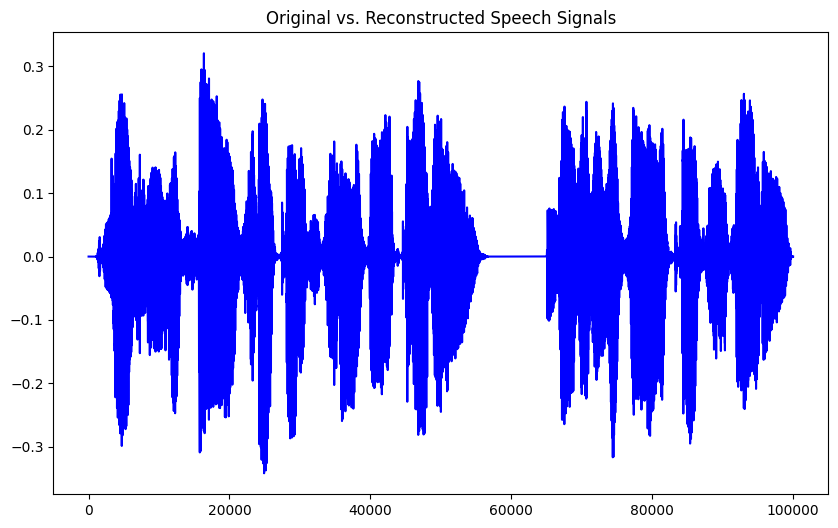

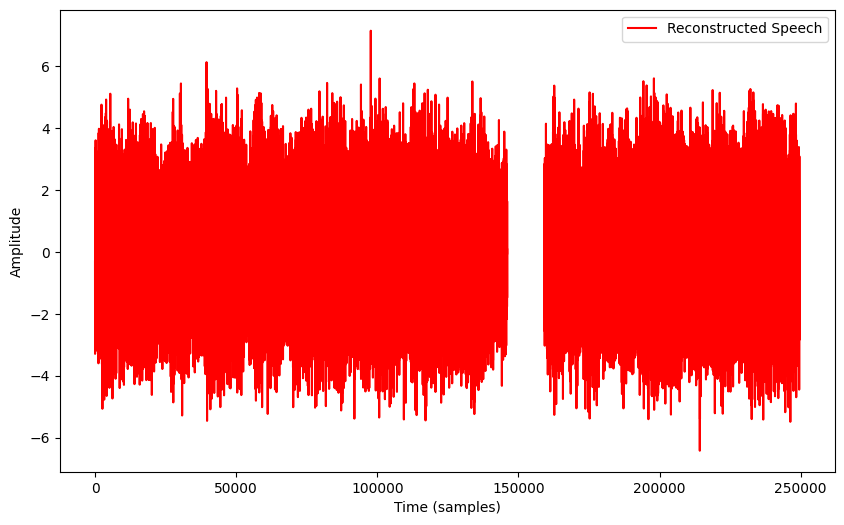

In [59]:
import matplotlib.pyplot as plt
reconstructed_signal = []
for i in range(len(lpc_coefficients)):
  a = np.concatenate(([1], -np.array(lpc_coefficients[i])))
  excitation = np.random.randn(frame_length)
  reconstructed_frame = np.convolve(excitation, a, mode='full')[:frame_length]
  reconstructed_signal.extend(reconstructed_frame)

reconstructed_signal = np.array(reconstructed_signal)

plt.figure(figsize=(10, 6))
plt.title("Original vs. Reconstructed Speech Signals")
plt.plot(speech_signal, label="Original Speech",color='blue')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(reconstructed_signal, label="Reconstructed Speech",color='red')
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [60]:
from scipy.signal import freqz
def estimate_formants(lpc_coeffs, fs):
  denominator = np.concatenate(([1], lpc_coeffs))
  roots = np.roots(denominator)
  roots = roots[np.abs(roots) < 1]
  angles = np.arctan2(np.imag(roots), np.real(roots))
  frequencies = angles * (fs / (2 * np.pi))
  frequencies = frequencies[frequencies > 0]
  return frequencies
formants = estimate_formants(lpc_coeffs, sr)
print("Estimated formants:", formants)

Estimated formants: [11025.]


In [63]:
def compare_formants_to_expected(estimated_formants, vowel):
  expected_formants = {
      'a': [700, 1100, 2500],
      'e': [500, 1900, 2600],
      'i': [300, 2300, 3000],
      'o': [500, 800, 2500],
      'u': [300, 900, 2300]
  }

  if vowel in expected_formants:
    print(f"Comparing estimated formants for vowel '{vowel}'")
    print("Estimated formants:", estimated_formants)
    print("Expected formants:", expected_formants[vowel])

    for i in range(min(len(estimated_formants), len(expected_formants[vowel]))):
        if abs(estimated_formants[i] - expected_formants[vowel][i]) < 200:
            print(f"Formant {i+1} is within acceptable range.")
        else:
            print(f"Formant {i+1} is outside of acceptable range.")
  else:
    print(f"Expected formant values for vowel '{vowel}' are not defined.")
for mfcc in formants:
  compare_formants_to_expected(formants, mfcc)

Expected formant values for vowel '11025.0' are not defined.


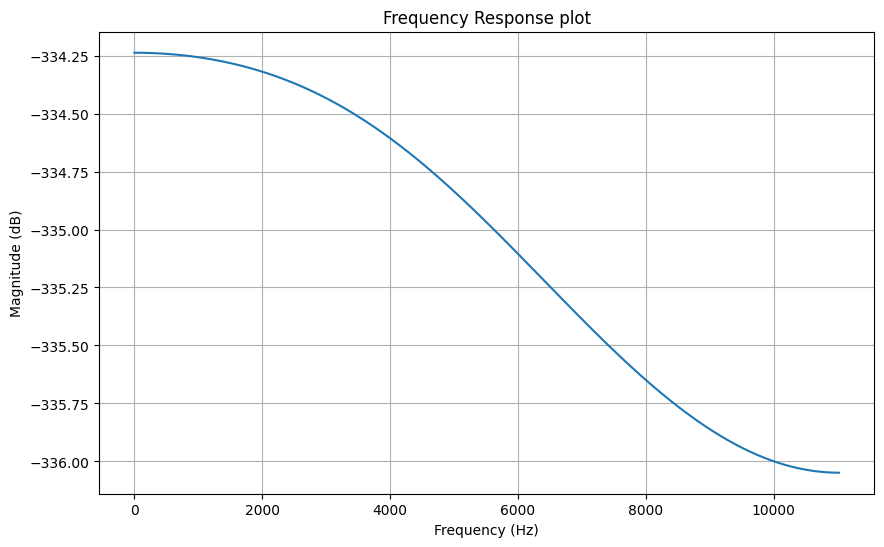

In [71]:
w, h = freqz(1, np.concatenate(([1], -lpc_coeffs)), worN=2048, fs=sr)
plt.figure(figsize=(10, 6))
plt.plot(w, 20 * np.log10(abs(h)))
plt.title('Frequency Response plot')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()